In [1]:
#from scipy import stats
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#%matplotlib inline
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from tqdm import tqdm
import corner
import emcee

(66454, 20)


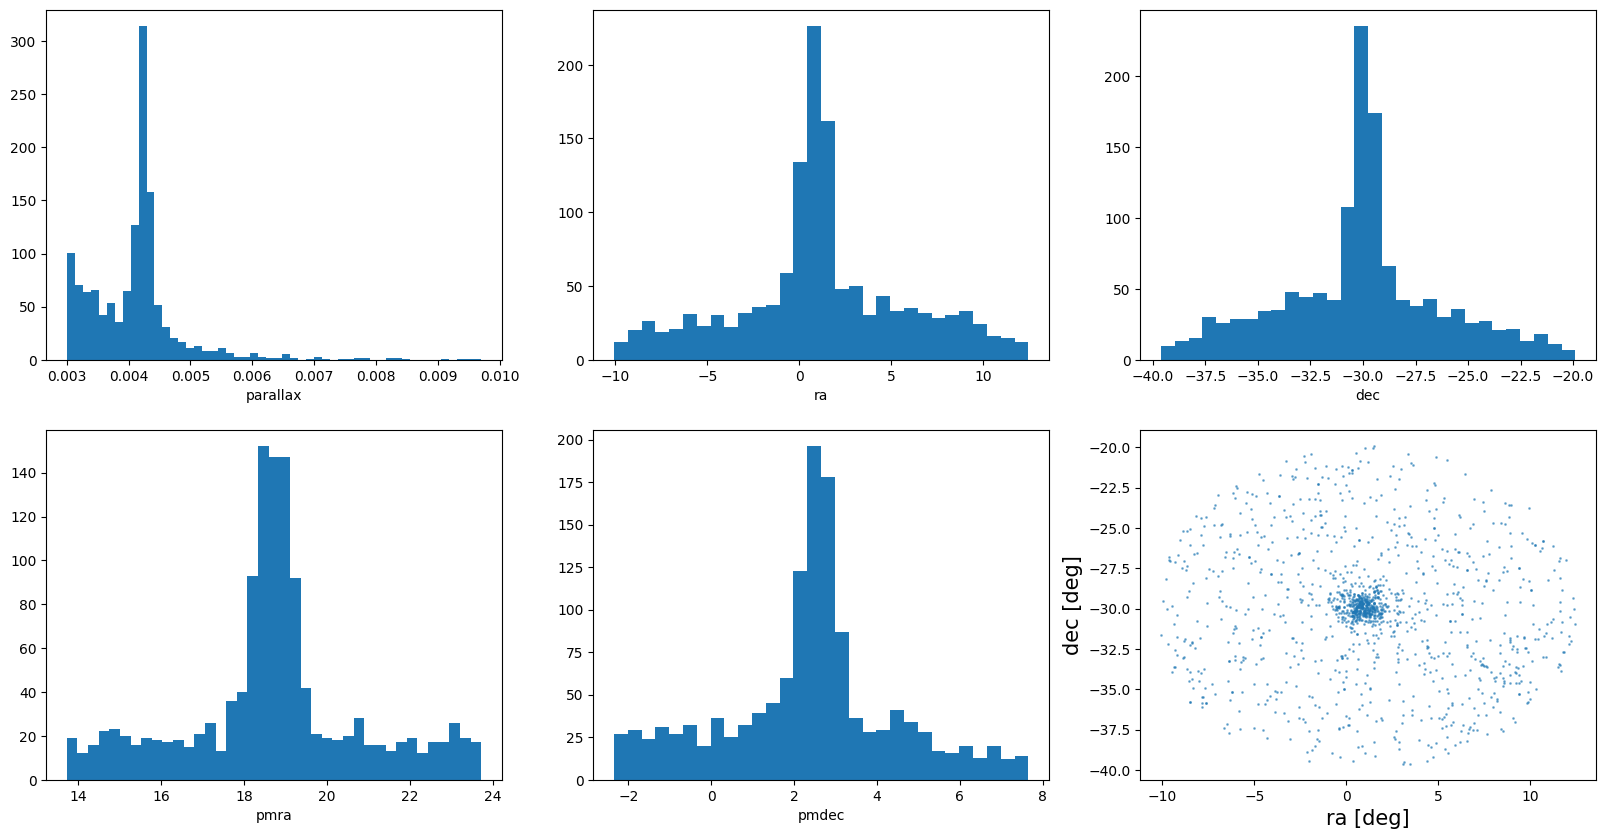

1319


In [2]:
df = pd.read_csv('./blanco1_10.csv')
df.loc[df['ra'] > 300, 'ra'] -= 360 #SOLO PARA BLANCO 1
df = df.fillna(0)
df['parallax'] = df['parallax'] / 1000
df['parallax_error'] = df['parallax_error'] / 1000
print(df.shape)

mu_alpha, mu_delta = 18.724, 2.650
rango = 5
c_pm=(df['pmra'] > mu_alpha - rango) & (df['pmra'] < mu_alpha + rango) & \
                        (df['pmdec'] > mu_delta - rango) & (df['pmdec'] < mu_delta + rango)
c_p = (df['parallax'] > 0.003) & (df['parallax'] < 0.01)

df = df[c_pm & c_p]

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(df.parallax,bins='auto')
plt.xlabel('parallax')

plt.subplot(2,3,2)
plt.hist(df.ra,bins='auto')
plt.xlabel('ra')

plt.subplot(2,3,3)
plt.hist(df.dec,bins='auto')
plt.xlabel('dec')

plt.subplot(2,3,4)
plt.hist(df.pmra,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmra')

plt.subplot(2,3,5)
plt.hist(df.pmdec,bins='auto')
#plt.xlim(-100,100)
plt.xlabel('pmdec')

plt.subplot(2,3,6)
plt.scatter(df['ra'], df['dec'], marker='o' , s=1, alpha = 0.5)
plt.xlabel("ra [deg]",  fontsize = 15)
plt.ylabel("dec [deg]",  fontsize = 15)#,rotation=0)
#plt.xlim(-30,0)
#plt.ylim(0,30)
plt.show()

print(len(df))

In [3]:
def gaussian_function(x, params):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    return nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)

def log_likelihood(params, x):
    nc, sc, sf, mu_c, mu_f = params
    Ac = -0.5*((x - mu_c)/sc)**2
    Be = -0.5*((x - mu_f)/sf)**2
    y = nc/(np.sqrt(2*np.pi)*sc)*np.exp(Ac) + (1-nc)/(np.sqrt(2*np.pi)*sf)*np.exp(Be)
    # Calculate log likelihood
    return np.sum(np.log(y))

def log_prior(params):
    nc, sc, sf, mu_c, mu_f = params
    if 0.0 < nc < 1.0 and 0.0 < sc < 10.0 and 0.0 < sf < 10.0:
        return 0.0
    return -np.inf

def log_probability(params, x):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x)

nll = lambda *args: -log_likelihood(*args)

In [4]:
sample_data = df.pmra
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmra = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmra, sample_data))
print(log_prior(initparams_pmra))
print(log_probability(initparams_pmra, sample_data))

results_pmra = minimize(nll, initparams_pmra, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmra.x

-2852.3081625105388
0.0
-2852.3081625105388


array([ 0.39165834,  0.37660488,  2.71058927, 18.71690849, 18.70933123])

In [5]:
sample_data = df.pmdec
sc, sf = np.std(sample_data)/2, np.std(sample_data)
mu_c, mu_f = np.mean(sample_data), np.mean(sample_data)
initparams_pmdec = [0.5, sc, sf, mu_c, mu_f]
print(log_likelihood(initparams_pmdec, sample_data))
print(log_prior(initparams_pmdec))
print(log_probability(initparams_pmdec, sample_data))

results_pmdec = minimize(nll, initparams_pmdec, args=(sample_data), options={"disc":True}, method='Nelder-Mead')
results_pmdec.x

-2856.0739944859038
0.0
-2856.0739944859038


array([0.30474692, 0.31997932, 2.48877737, 2.58162045, 2.2785303 ])

Text(0.5, 0, 'pmdec')

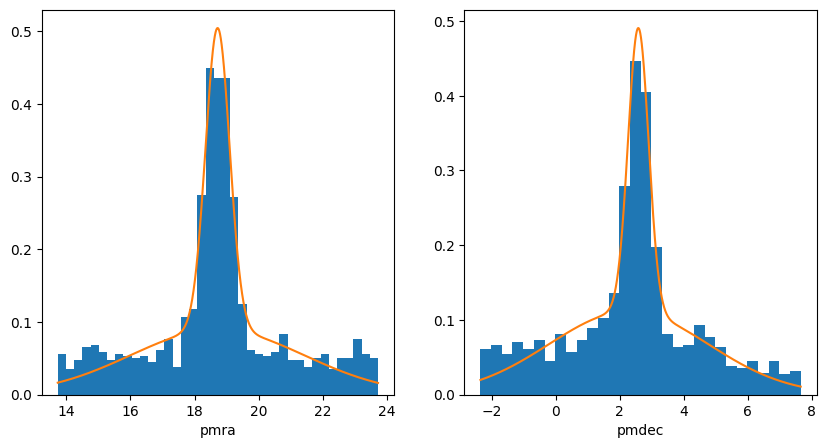

In [6]:
plt.figure(figsize=(10,5))
sample_data = df.pmra
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmra.x))
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, results_pmdec.x))
plt.xlabel('pmdec')

In [7]:
sample_data = df.pmra
n_walkers, n_dim = 250, 5
p0 = results_pmra.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmra = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmra.run_mcmc(p0, 500, progress = True)

100%|█████████████████████████████████████████| 500/500 [01:58<00:00,  4.21it/s]


Text(0.5, 0, 'step number')

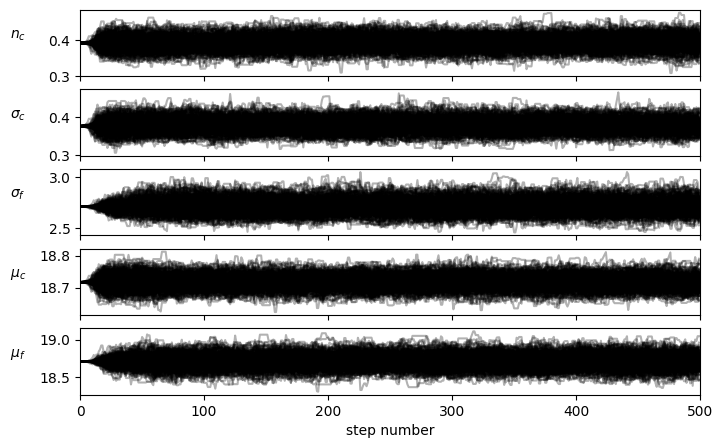

In [8]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmra.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Minimize: [ 0.39165834  0.37660488  2.71058927 18.71690849 18.70933123]
MCMC:     [ 0.39123464  0.37261381  2.72432929 18.72263618 18.66895655]
(6500, 5)


<Figure size 800x800 with 0 Axes>

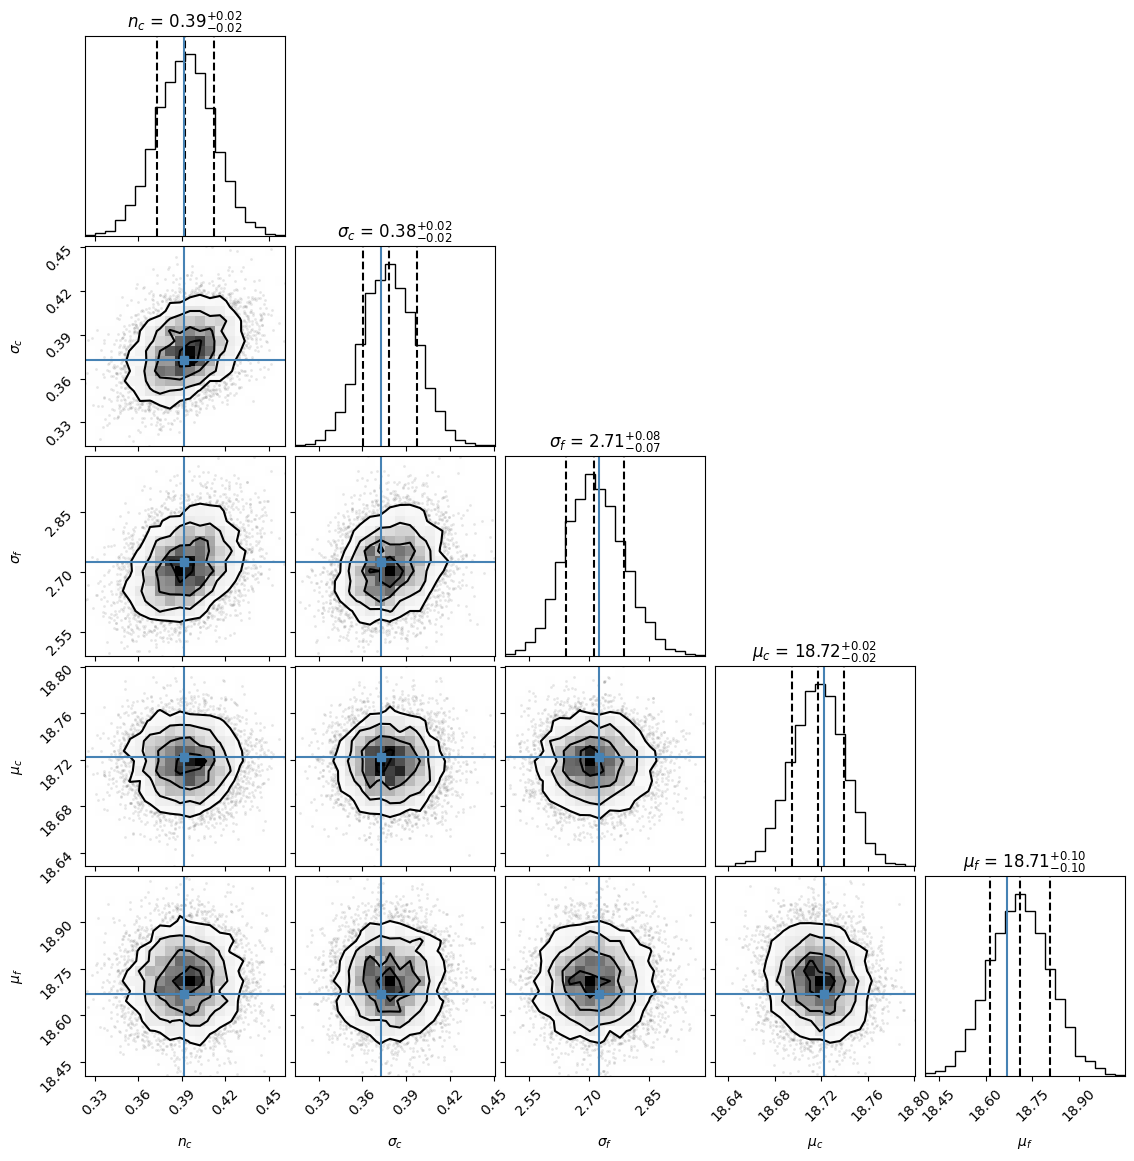

In [9]:
#tau = sampler.get_autocorr_time()
#print(tau)
maxprob_indice = np.argmax(prob)
params_mcmc_pmra = pos[maxprob_indice]
#params_mcmc_pmra = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmra.x)
print('MCMC:    ',params_mcmc_pmra)

flat_samples = sampler_pmra.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmra
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

In [10]:
sample_data = df.pmdec
n_walkers, n_dim = 250, 5
p0 = results_pmdec.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler_pmdec = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[sample_data])
pos, prob, state = sampler_pmdec.run_mcmc(p0, 500, progress = True)

100%|█████████████████████████████████████████| 500/500 [01:59<00:00,  4.19it/s]


Text(0.5, 0, 'step number')

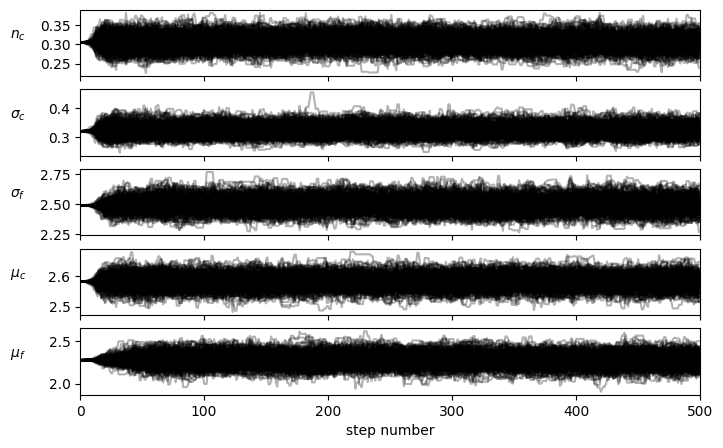

In [11]:
fig, axes = plt.subplots(n_dim, figsize=(8, 5), sharex=True)
samples = sampler_pmdec.get_chain()
labels = ["$n_c$", "$\sigma_c$", "$\sigma_f$", "$\mu_c$", "$\mu_f$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

Minimize: [0.30474692 0.31997932 2.48877737 2.58162045 2.2785303 ]
MCMC:     [0.31321968 0.3314861  2.50892119 2.57128995 2.29861056]
(6500, 5)


<Figure size 800x800 with 0 Axes>

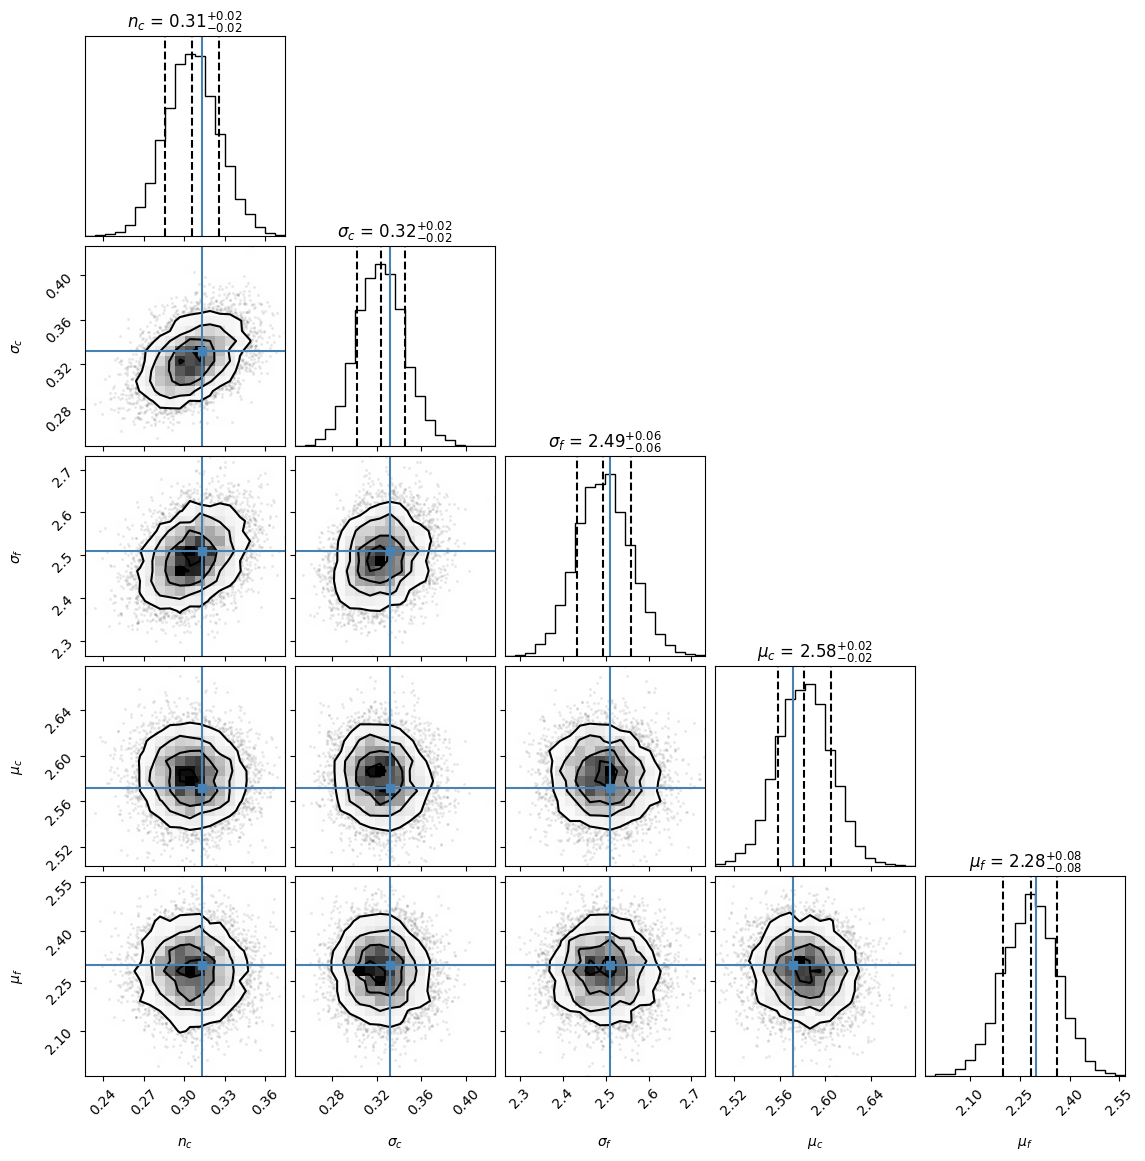

In [12]:
#tau = sampler.get_autocorr_time()
#print(tau)
maxprob_indice = np.argmax(prob)
params_mcmc_pmdec = pos[maxprob_indice]
#params_mcmc_pmdec = np.percentile(pos ,50, axis=0)
print('Minimize:',results_pmdec.x)
print('MCMC:    ',params_mcmc_pmdec)

flat_samples = sampler_pmdec.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

truths = params_mcmc_pmdec
plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})

Text(0.5, 0, 'pmdec')

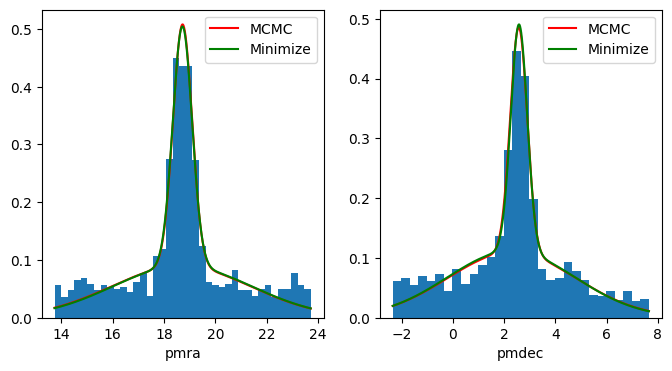

In [13]:
sample_data = df.pmra
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmra), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmra.x), label='Minimize', color='green')
plt.legend()
plt.xlabel('pmra')

plt.subplot(1,2,2)
sample_data = df.pmdec
bin_heights, bin_borders, _ = plt.hist(sample_data, bins='auto',
                                       range=(min(sample_data),max(sample_data)),density=True)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x, gaussian_function(x, params_mcmc_pmdec), label='MCMC',color='red')
plt.plot(x, gaussian_function(x, results_pmdec.x), label='Minimize',color='green')
plt.legend()
plt.xlabel('pmdec')

In [14]:
def log_prior(params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    if 0.0 < nc < 1.0 and 0.0 < s < 10.0 and 0.0 < sx < 10.0 and 0.0 < sy < 10.0 and -1.0 < rho < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(params, x, y):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    # Calculate log likelihood
    return np.sum(np.log(z))

def log_probability(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)

In [15]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf
rho_matrix = np.corrcoef(df.pmra, df.pmdec)
initparams = [0.5, results_pmra.x[1], results_pmra.x[2], results_pmdec.x[2], rho_matrix[0][1],
       results_pmra.x[3], results_pmdec.x[3], results_pmra.x[4], results_pmdec.x[4]]
print(initparams)
print(log_likelihood(initparams, x, y))
print(log_prior(initparams))
print(log_probability(initparams, x, y))

nll = lambda *args: -log_likelihood(*args)

results = minimize(nll, initparams, args=(x, y), options={"disc":True}, method='Nelder-Mead')
results.x

[0.5, 0.37660488194819, 2.710589268776126, 2.4887773729398934, 0.005438692177041275, 18.716908489737023, 2.581620448400767, 18.70933123204756, 2.2785302983957543]
-5100.656780174095
0.0
-5100.656780174095


array([3.77563169e-01, 3.81145132e-01, 2.68047779e+00, 2.62001150e+00,
       5.97451542e-03, 1.87253873e+01, 2.58418952e+00, 1.87043317e+01,
       2.24143208e+00])

In [16]:
x = df.pmra
y = df.pmdec
#nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf

n_walkers, n_dim = 250, 9
p0 = results.x + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=[x, y])
pos, prob, state = sampler.run_mcmc(p0, 5000, progress = True)

100%|███████████████████████████████████████| 5000/5000 [37:50<00:00,  2.20it/s]


Text(0.5, 0, 'step number')

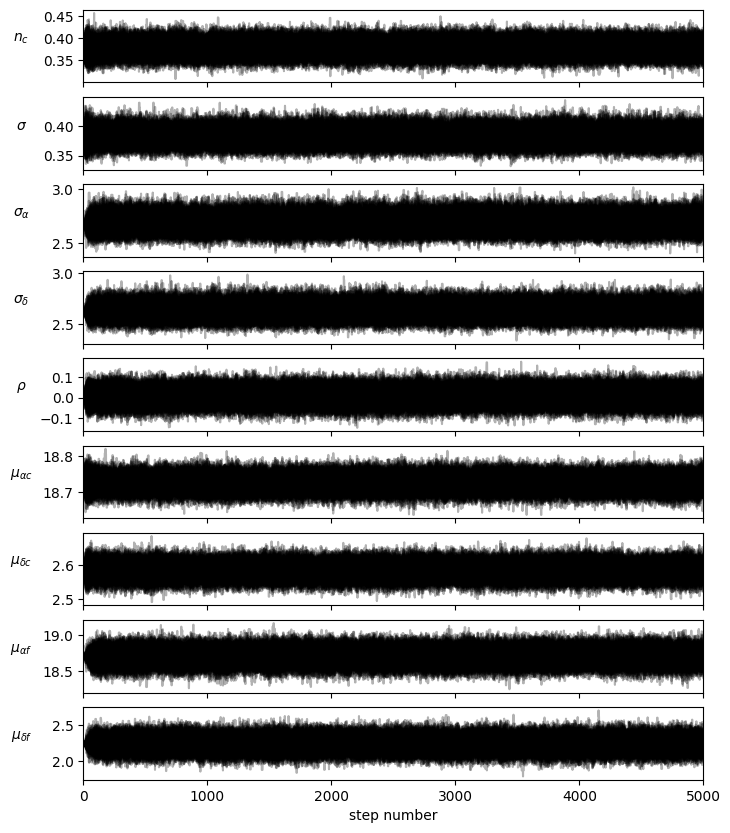

In [17]:
fig, axes = plt.subplots(n_dim, figsize=(8, 10), sharex=True)
samples = sampler.get_chain()
labels = ["$n_c$", "$\sigma$", "$\sigma_{\\alpha}$", "$\sigma_{\delta}$", "$\\rho$",
          "$\mu_{\\alpha c}$", "$\mu_{\delta c}$", "$\mu_{\\alpha f}$", "$\mu_{\delta f}$"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

Minimize: [3.77563169e-01 3.81145132e-01 2.68047779e+00 2.62001150e+00
 5.97451542e-03 1.87253873e+01 2.58418952e+00 1.87043317e+01
 2.24143208e+00]
MCMC:     [3.90103463e-01 3.92580890e-01 2.68855333e+00 2.66960534e+00
 5.15339658e-03 1.87324300e+01 2.58031043e+00 1.86907302e+01
 2.27826814e+00]
(81500, 9)


<Figure size 800x800 with 0 Axes>

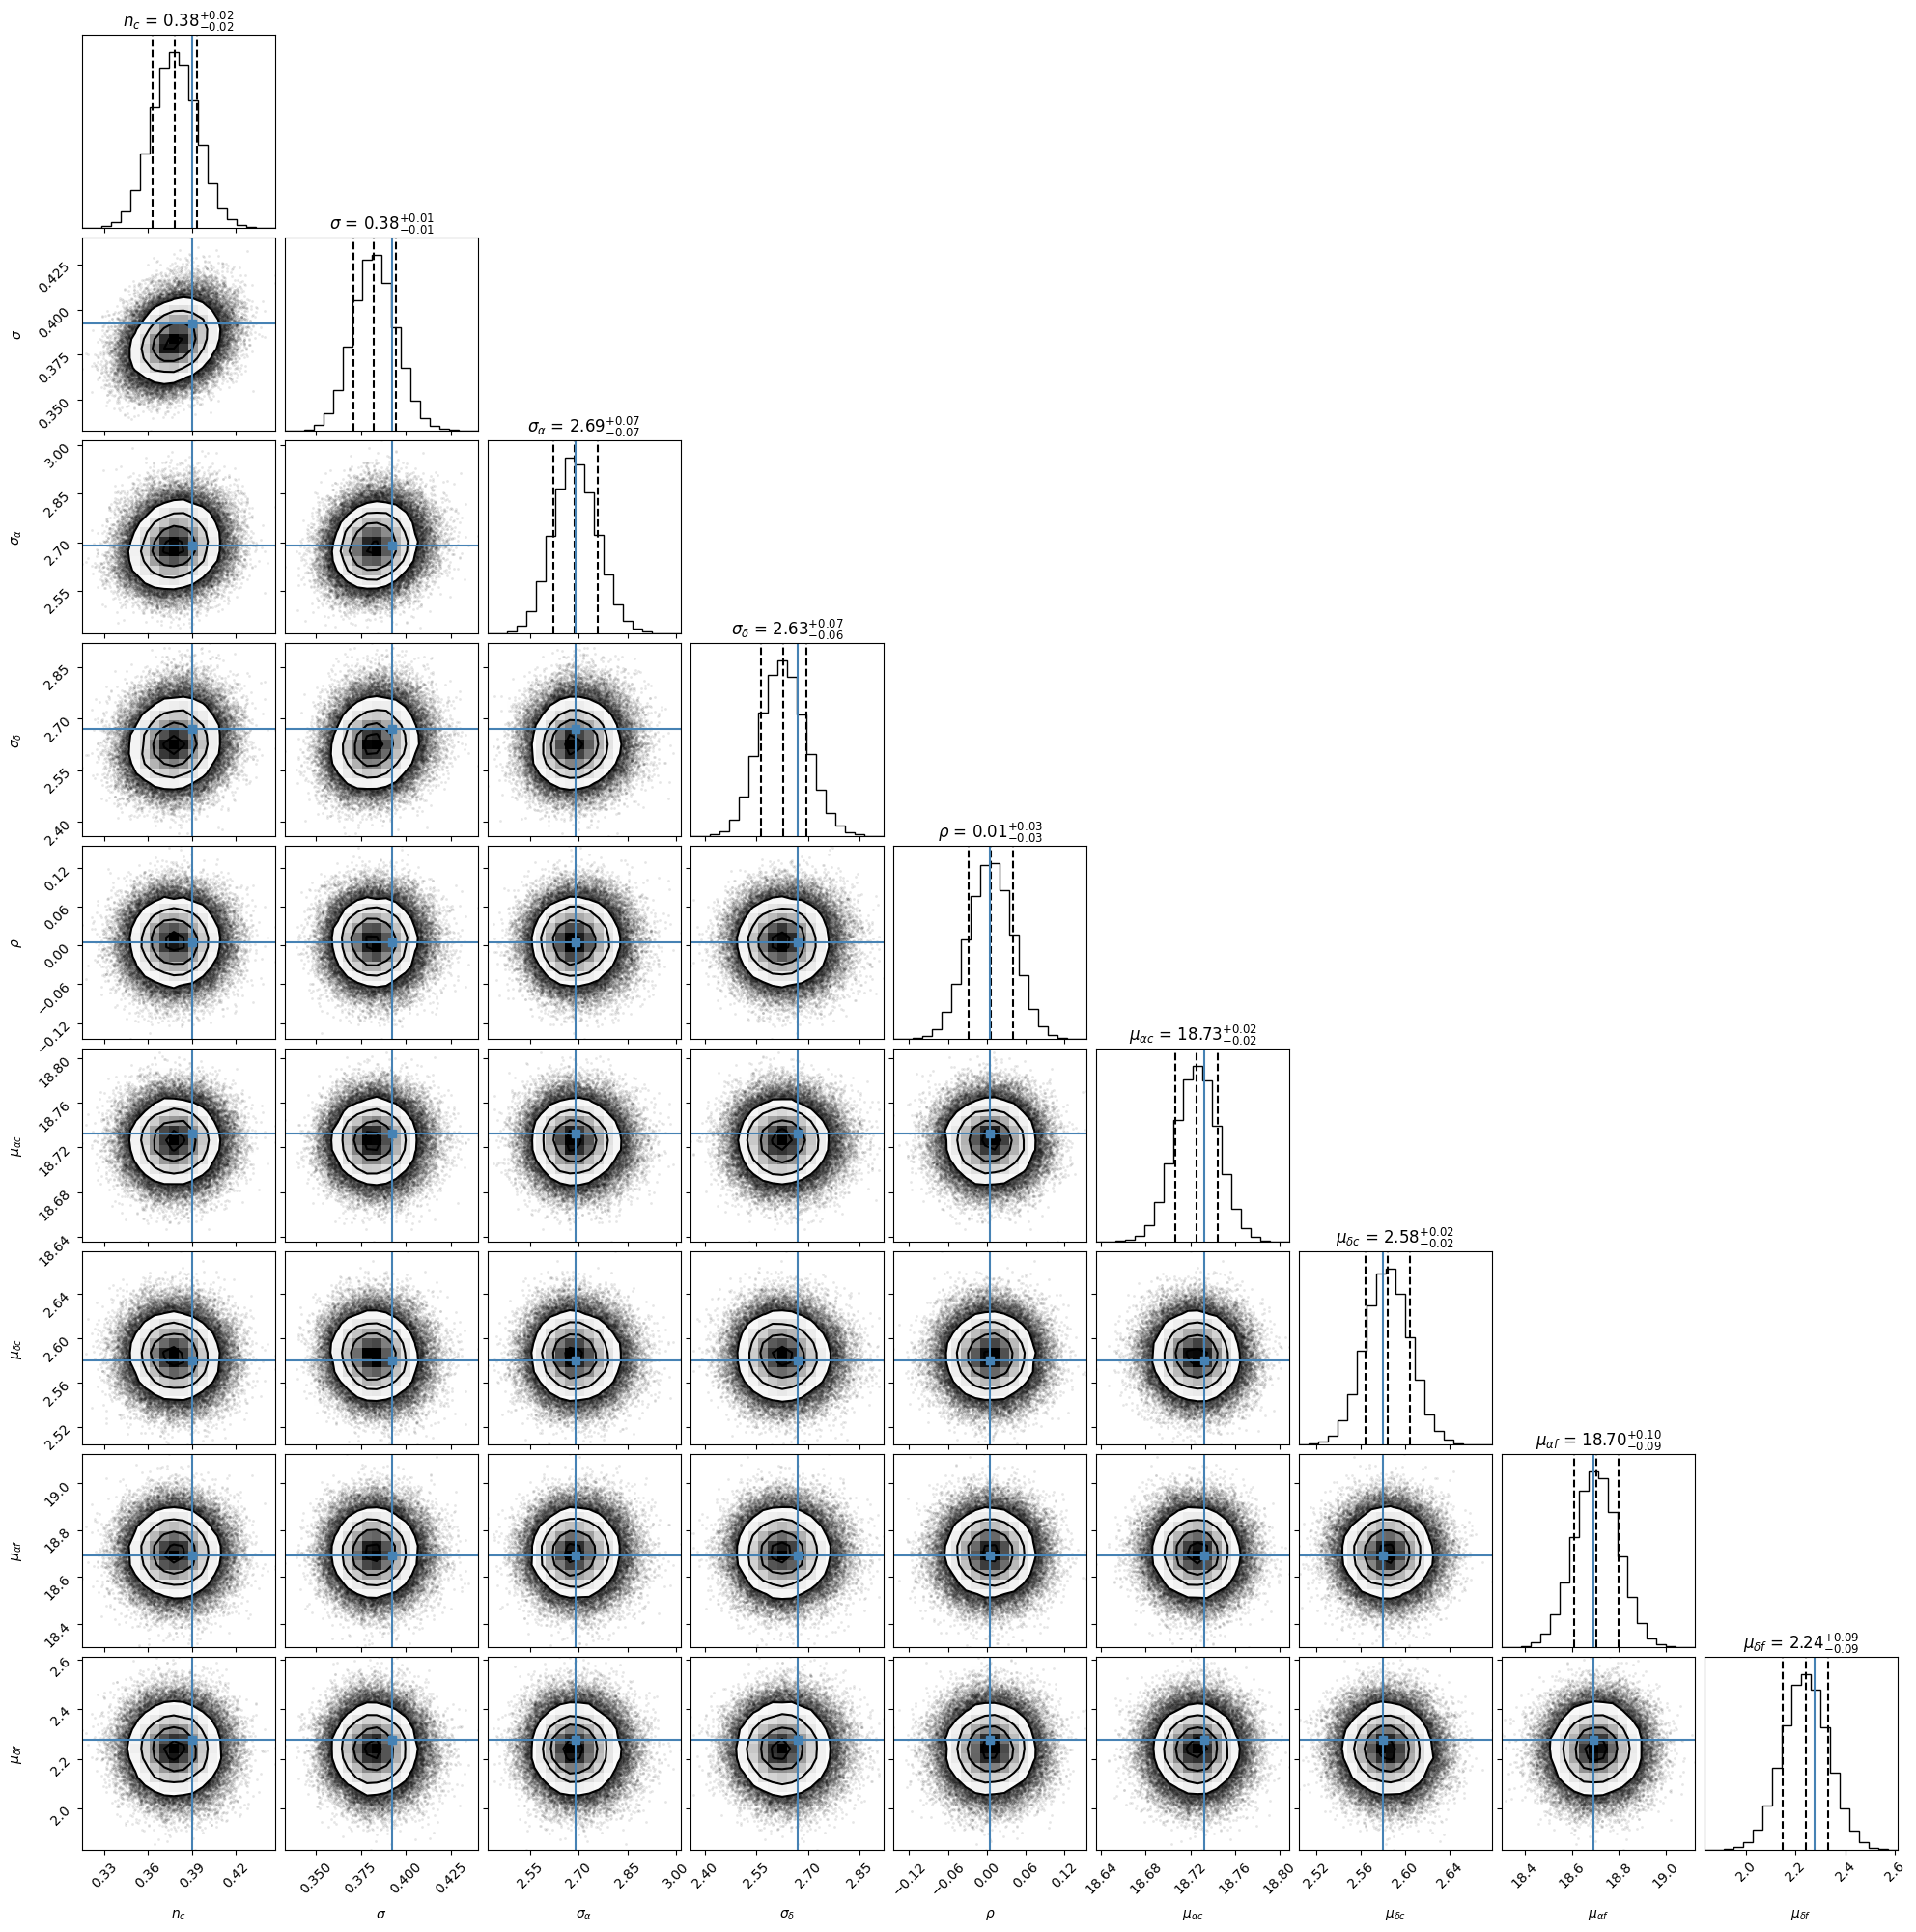

In [19]:
#params_mcmc = np.percentile(pos ,50, axis=0)
maxprob_indice = np.argmax(prob)
params_mcmc = pos[maxprob_indice]

print('Minimize:',results.x)
print('MCMC:    ',params_mcmc)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
truths = params_mcmc

plt.figure(figsize=(8,8))
fig = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                      title_kwargs={"fontsize": 12})
#plt.savefig('./corner.png',bbox_inches = "tight")

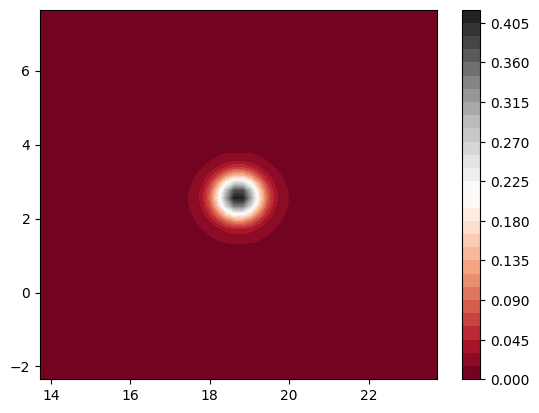

In [20]:
x = np.linspace(min(df.pmra), max(df.pmra), 50)
y = np.linspace(min(df.pmdec), max(df.pmdec), 50)

def func(x, y, params):
    nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = params
    amp_circ = nc / (2 * np.pi * s**2)
    amp_elip = (1-nc) / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_circ = -0.5 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    Exp_elip = -1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    z = amp_circ * np.exp(Exp_circ) + amp_elip * np.exp(Exp_elip)
    return z


X, Y = np.meshgrid(x, y)
Z = func(X, Y, results.x)

plt.contourf(X, Y, Z, 30, cmap='RdGy')
plt.colorbar()

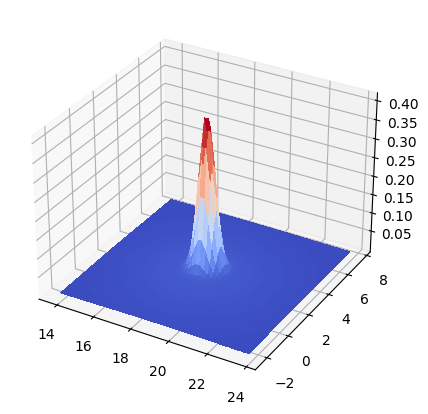

In [21]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(5, 5))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

0.9672786384862674


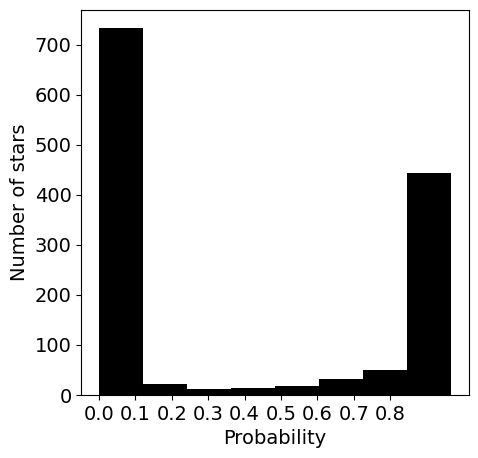

In [22]:
#nf, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = truths
nc, s, sx, sy, rho, mu_xc, mu_yc, mu_xf, mu_yf = results.x

def probabilidad_circ(xy, nc, s, mu_xc, mu_yc):
    x, y = xy
    amp_circ =  1 / (2 * np.pi * s**2)
    Exp_circ = - 1/2 * (((x - mu_xc)/s)**2 + ((y - mu_yc)/s)**2)
    return nc * amp_circ * np.exp(Exp_circ)

def probabilidad_elip(xy, nc, sx, sy, rho, mu_xf, mu_yf):
    x, y = xy
    amp_elip = 1 / (2 * np.pi * sx * sy * np.sqrt(1 - rho**2))
    Exp_elip = - 1/(2*(1-rho**2))*(((x - mu_xf)/sx)**2+((y - mu_yf)/sy)**2-2*rho*((x - mu_xf)/sx)*((y - mu_yf)/sy))
    return (1-nc) * amp_elip * np.exp(Exp_elip)

xy = np.vstack((df.pmra, df.pmdec))
param_circ_prob = (nc, s, mu_xc, mu_yc)
param_elip_prob = (nc, sx, sy, rho, mu_xf, mu_yf)
p_circ = probabilidad_circ(xy, *param_circ_prob)
p_elip = probabilidad_elip(xy, *param_elip_prob)
prob = p_circ / (p_circ + p_elip)
#print('Min: {:.10f} Max: {:.10f}'.format(min(prob), max(prob)))
prob_limit = 0.5
members = (prob >= prob_limit)
no_members = (prob < prob_limit)
print(max(prob))
plt.figure(figsize=(5,5))
#plt.hist(prob, bins=5,range=[min(prob), 0.5], label='Field stars',color='gray')
#plt.hist(prob[(prob > 0.5)], bins=5,color='cyan',label='Cluster stars')
plt.hist(prob, bins=8,range=[min(prob), max(prob)],color='black')#histtype='step'
plt.xlabel('Probability',fontsize=14)
plt.ylabel('Number of stars',fontsize=14)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
#plt.axvline(x = 0.5, color = 'black', label = 'Cut off', linestyle = '--')
#plt.legend()
#plt.savefig('./results/pleiades_probabilities.jpg',bbox_inches = "tight")
plt.show()

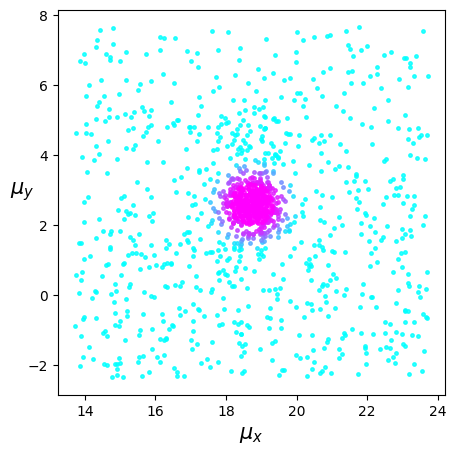

In [23]:
#colors=['black','dimgray','darkgrey','gainsboro','wheat','rosybrown','lightcoral','indianred','salmon','red']
#loop = np.arange(0.0, 1.0, 0.1)
loop = np.arange(0.0, 1.0, 0.1)
colors = [plt.cm.cool(each) for each in np.linspace(0, 1, len(loop))]

plt.figure(figsize=(5,5))
for i,c in zip(loop, colors):
  cond = (prob >= i) & (prob < i + 0.1)
  pmra_, pmdec_ = df.pmra[(cond)], df.pmdec[(cond)]
  plt.plot(pmra_, pmdec_,marker='.',c=c,linestyle='None',markersize=5,alpha=0.8)
plt.xlabel("$\mu_{x}$", fontsize = 15)
plt.ylabel("$\mu_{y}$", fontsize = 15,rotation=0)
#plt.savefig('./VPDClasses.jpg')
plt.show()

In [24]:
df['probability'] = prob
b1_members = df[members]
#m45_members.to_csv('./pleiades_PMmodel.csv')
print(len(b1_members))
b1_members

539


,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,...,g,g_error,rp,rp_error,bp,bp_error,rv,rv_error,ruwe,probability
26,2321410616394529664,2.013105,0.107889,-28.542634,0.102375,0.004267,0.000146,18.351631,0.133112,2.101319,...,18.220442,1.336923,16.946337,10.147861,19.945133,7.576601,0.000000,0.000000,0.992830,0.891401
39,2321413949289499776,1.599337,0.112898,-28.675197,0.100794,0.004423,0.000139,18.618613,0.156241,3.016445,...,17.655039,3.992293,16.350252,12.587383,19.331076,10.460187,0.000000,0.000000,1.212060,0.939368
50,2321415770355639808,1.604525,0.074902,-28.626529,0.074045,0.004132,0.000098,18.968678,0.101875,3.005427,...,17.500357,2.161768,16.253736,11.642471,19.157602,11.841854,0.000000,0.000000,0.964683,0.931577
72,2321418828372357376,1.606949,0.123728,-28.601757,0.123154,0.003446,0.000164,19.340565,0.167229,2.515916,...,18.316202,1.497755,17.052030,13.819158,20.121040,8.237848,0.000000,0.000000,1.020896,0.890253
91,2321422436144254464,1.723788,0.010863,-28.519087,0.009532,0.004314,0.000012,19.001442,0.015245,2.876101,...,12.249480,253.744630,11.699513,335.268280,12.625168,345.664300,5.849659,0.816092,0.980313,0.945738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63426,6552310228837948416,-8.395708,0.092235,-34.385971,0.105168,0.004139,0.000122,18.638418,0.100169,2.100478,...,17.884178,2.214029,16.648352,9.659335,19.480875,11.495305,0.000000,0.000000,0.939673,0.927493
64068,6555597596806155904,-9.365232,0.159787,-33.601228,0.181804,0.003893,0.000210,19.419437,0.177755,2.465610,...,18.721153,1.564510,17.436610,12.904814,20.596704,6.808631,0.000000,0.000000,0.982341,0.846988
64185,6551047508455099136,-8.474498,0.015632,-35.815960,0.024522,0.003472,0.000022,18.279932,0.017693,1.694149,...,10.490845,449.734740,9.937252,38012.630000,10.604478,12175.455000,-6.146955,0.990563,1.125977,0.500769
64743,6551351081036094080,-7.869775,0.052169,-36.069601,0.059183,0.004240,0.000071,18.710232,0.058153,2.427297,...,16.768750,3.594643,15.602242,13.329209,18.147795,16.311998,0.000000,0.000000,0.986898,0.964271
